# COVID-19 X-ray classification 

## `Importing libraries & exploring the images`

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 133 kB 4.4 MB/s 


In [ ]:
import os
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

from keras.applications.vgg16 import preprocess_input as preprocess_vgg, VGG16
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_IV3
from keras.applications.resnet import ResNet50, preprocess_input as preprocess_RN

from joblib import dump, load

In [ ]:
covid_img_path = '/content/drive/MyDrive/COVID-19 Project/Dataset/train/COVID/0a7faa2a.jpg'
normal_img_path = '/content/drive/MyDrive/COVID-19 Project/Dataset/train/NORMAL/IM-0152-0001.jpeg'

img_cov = load_img(covid_img_path, target_size = (256,256))
img_nr = load_img(normal_img_path, target_size = (256,256))


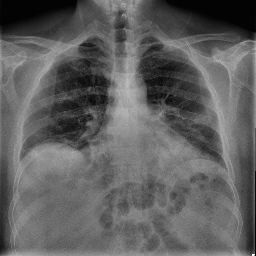

In [ ]:
img_cov

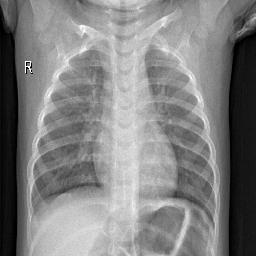

In [ ]:
img_nr

In [ ]:
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

normal_imgs = os.listdir('/content/drive/MyDrive/COVID-19 Project/Dataset/train/NORMAL')
covid_imgs = os.listdir('/content/drive/MyDrive/COVID-19 Project/Dataset/train/COVID')
train_dir = '/content/drive/MyDrive/COVID-19 Project/Dataset/train'
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
covid_images = img2np(f'{train_dir}/COVID/', covid_imgs)

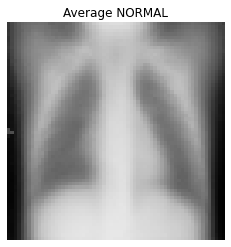

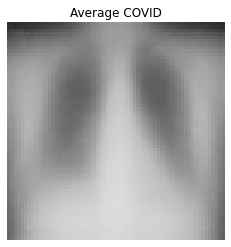

In [ ]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
cov_mean = find_mean_img(covid_images, 'COVID')

We can see more obstruction in the upper part of the lungs in case of COVID positive lungs.

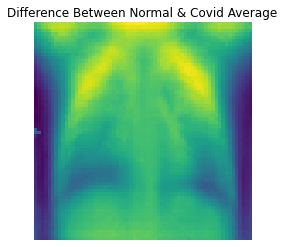

In [ ]:
contrast_mean = norm_mean - cov_mean
plt.imshow(contrast_mean)
plt.title(f'Difference Between Normal & Covid Average')
plt.axis('off')
plt.show()

Number of PC:  25


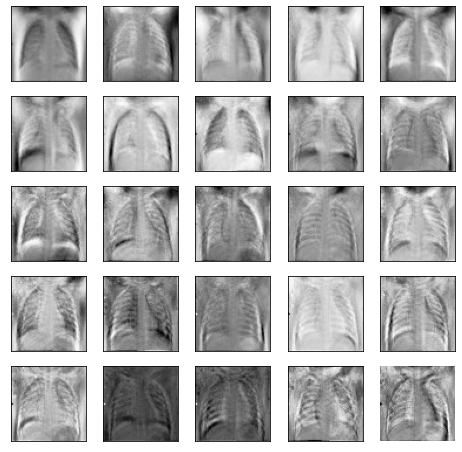

Number of PC:  9


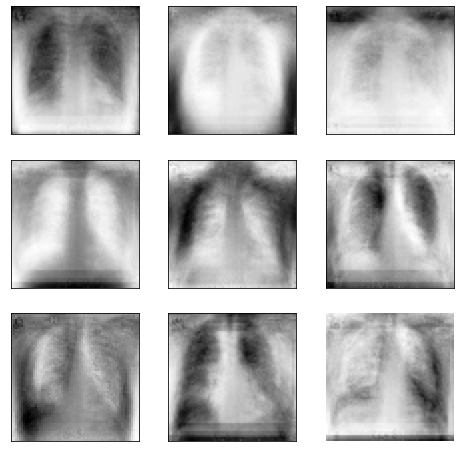

In [ ]:
from sklearn.decomposition import PCA
from math import ceil
## 75% variability 
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_images, 'NORMAL', n_comp = 0.75))
plot_pca(eigenimages(covid_images, 'COVID', n_comp = 0.75))

## `Preparing the data`

In [ ]:
def DataGen(train_path, val_path, preprocess_func = None, scale = 1/255.0):
  train_gen = ImageDataGenerator(rescale = scale,
                               rotation_range = 0.05,
                               width_shift_range = 0.05,
                               height_shift_range = 0.05,
                               fill_mode = 'nearest',
                               brightness_range = [0.4, 1.5],
                               zoom_range = 0.05,
                               preprocessing_function = preprocess_func
                               )
  train_iter = train_gen.flow_from_directory(train_path,
                                           class_mode = 'binary',
                                           batch_size = 8,
                                           seed = 1)
  

  val_gen = ImageDataGenerator(rescale = scale,
                               rotation_range = 0.05,
                               width_shift_range = 0.05,
                               height_shift_range = 0.05,
                               fill_mode = 'nearest',
                               brightness_range = [0.4, 1.5],
                               zoom_range = 0.05,
                               preprocessing_function = preprocess_func
                               )
  val_iter = val_gen.flow_from_directory(val_path,
                                           class_mode = 'binary',
                                           batch_size = 8,
                                           seed = 1)
  return train_iter, val_iter

In [ ]:
train_path = '/content/drive/MyDrive/COVID-19 Project/Dataset/train'
val_path = '/content/drive/MyDrive/COVID-19 Project/Dataset/test'

In [ ]:
train_iter, val_iter = DataGen(train_path, val_path)

Found 294 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


## `Model Building`

In [ ]:
def train_model(model, loss, optimizer, metrics, epochs = 25, callbacks = None):
  model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
  hist = model.fit(train_iter, epochs = epochs, validation_data = val_iter, callbacks = callbacks)
  return hist

In [ ]:
def plot_loss_metrics(hist):
  fig, ax = plt.subplots(1, 2, figsize = (15,7))
  ax[0].plot(hist.history['accuracy'])
  ax[0].plot(hist.history['val_accuracy'])
  ax[0].legend(['train', 'validation'])
  
  ax[1].plot(hist.history['loss'])
  ax[1].plot(hist.history['val_loss'])
  ax[1].legend(['train', 'validation'])
  plt.show()

In [ ]:
def preds(img_path, model, best_weights_path, preprocess = None):
  img=load_img(img_path,target_size=(256, 256)) #The path of the testing image,the pic taken from the phone should come here
  img=np.asarray(img)
  plt.imshow(img)
  if preprocess == None:
    img = img/255.0
  else:
  #  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess(img)
  
  img=np.expand_dims(img,axis=0)
  model.load_weights(best_weights_path)

  output=model.predict(img) #predicting the image using model created

  if(output[0][0]<0.6): #comparison
      print("The probability of the patient having COVID-19 is {}".format(1 - output[0][0]))
  else:
      print("The probability of the patient not having COVID-19 is {}".format(output[0][0]))


def random_preds(model, best_weights_path, preprocess = None):
  print('FOR COVID POSITIVE PATIENTS:')
  print('-----------------------------')
  covid = os.listdir('/content/drive/MyDrive/COVID-19 Project/Dataset/test/COVID')
  random.shuffle(covid)
  for file_name in covid[:5]:
    path = os.path.join('/content/drive/MyDrive/COVID-19 Project/Dataset/test/COVID', file_name)
    preds(path, model, best_weights_path, preprocess = preprocess)
    print('----------------------------')

  print('------------------------------')
  print('FOR NORMAL PATIENTS:')
  nr = os.listdir('/content/drive/MyDrive/COVID-19 Project/Dataset/test/NORMAL')
  random.shuffle(nr)
  for file_name in nr[:5]:
    path = os.path.join('/content/drive/MyDrive/COVID-19 Project/Dataset/test/NORMAL', file_name)
    preds(path, model, best_weights_path, preprocess = preprocess)
    print('----------------------------')
  

In [ ]:
# for testing
cov = '/content/drive/MyDrive/COVID-19 Project/Dataset/test/COVID/10.1016-slash-j.crad.2020.04.002-a.png'
nr = '/content/drive/MyDrive/COVID-19 Project/Dataset/test/NORMAL/IM-0317-0001.jpeg'
path1 = '/content/drive/MyDrive/COVID-19 Project/COVID POSITIVE PATIENT IN LATUR'

### 1. Simple CNN Model

In [ ]:
model1 = Sequential()
model1.add(InputLayer(input_shape = (256,256,3)))
model1.add(Conv2D(25, (5,5), activation = 'relu', strides = (1,1), padding = 'valid'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Conv2D(50, (5,5), activation = 'relu', strides = (1,1), padding = 'valid'))
model1.add(MaxPool2D(pool_size = (2,2)))
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [ ]:
path = 'best_weights.hdf5'
ES_clbk = EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0)
mdl_chkpnt = ModelCheckpoint(path, monitor = 'val_accuracy', mode = 'max', save_best_only=True, verbose = 1)

In [ ]:
hist = train_model(model1, loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'], callbacks = [ES_clbk, mdl_chkpnt])

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.7007
Epoch 1: val_accuracy improved from -inf to 0.91837, saving model to best_weights.hdf5
37/37 [==============================] - 97s 2s/step - loss: 0.8924 - accuracy: 0.7007 - val_loss: 0.2872 - val_accuracy: 0.9184
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.8776
Epoch 2: val_accuracy did not improve from 0.91837
37/37 [==============================] - 78s 2s/step - loss: 0.4109 - accuracy: 0.8776 - val_loss: 0.2349 - val_accuracy: 0.9184
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9116
Epoch 3: val_accuracy improved from 0.91837 to 0.96939, saving model to best_weights.hdf5
37/37 [==============================] - 79s 2s/step - loss: 0.2440 - accuracy: 0.9116 - val_loss: 0.1741 - val_accuracy: 0.9694
Epoch 4/25
37/37 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.9184
Epoch 4: 

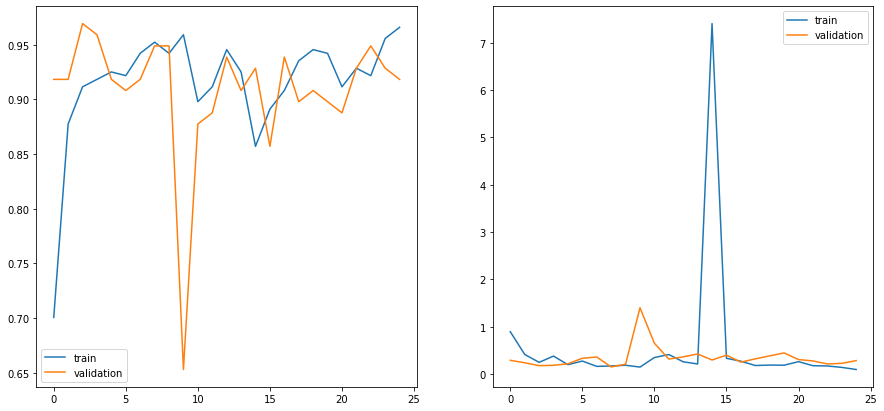

In [ ]:
plot_loss_metrics(hist)

The probability of the patient having COVID-19 is 0.8258968591690063


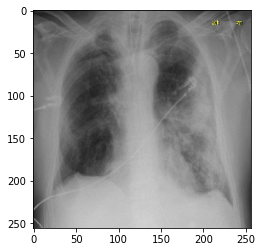

In [ ]:
img = load_img(cov)
img
preds(cov, model1, '/content/best_weights.hdf5')

The probability of the patient not having COVID-19 is 0.9960419535636902


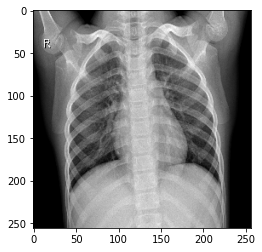

In [ ]:
img = load_img(nr)
img
preds(nr, model1, '/content/best_weights.hdf5')

FOR COVID POSITIVE PATIENTS:
-----------------------------
The probability of the patient having COVID-19 is 0.999391108751297
----------------------------
The probability of the patient having COVID-19 is 0.7031572461128235
----------------------------
The probability of the patient having COVID-19 is 0.8074816167354584
----------------------------
The probability of the patient having COVID-19 is 0.9060252010822296
----------------------------
The probability of the patient having COVID-19 is 0.9972368478775024
----------------------------
------------------------------
FOR NORMAL PATIENTS:
The probability of the patient not having COVID-19 is 0.9812095761299133
----------------------------
The probability of the patient not having COVID-19 is 0.9998103380203247
----------------------------
The probability of the patient not having COVID-19 is 0.996761679649353
----------------------------
The probability of the patient not having COVID-19 is 0.9985398054122925
----------------------

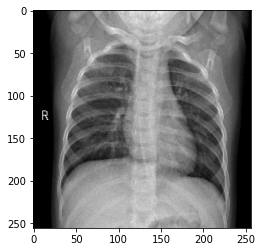

In [ ]:
random_preds(model1, '/content/best_weights.hdf5')

The probability of the patient having COVID-19 is 0.9576744437217712


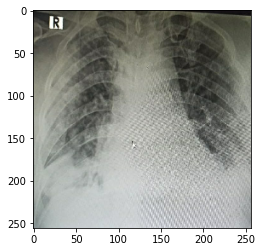

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model1, '/content/best_weights.hdf5') 

In [ ]:
dump(model1, 'SimpleCNN.joblib')

INFO:tensorflow:Assets written to: ram://5ec275e6-e081-4cb4-89b7-b2c1871d3a07/assets


['SimpleCNN.joblib']

### 2. CNN with Dropout, Batch Normalization, Weight Initialization & Same padding

In [ ]:
model2 = Sequential()
model2.add(InputLayer(input_shape = (256,256,3)))
model2.add(Conv2D(25, (5,5), activation = 'relu', strides = (1,1), padding = 'same'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(50, (5,5), activation = 'relu', strides = (1,1), padding = 'same'))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(64, activation = 'relu', kernel_initializer = 'he_normal'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(64, activation = 'relu', kernel_initializer = 'he_normal'))
model2.add(Dense(1, activation = 'sigmoid'))

In [ ]:
path = 'best_weights2.hdf5'
ES_clbk = EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0)
mdl_chkpnt = ModelCheckpoint(path, monitor = 'val_accuracy', mode = 'max', save_best_only=True, verbose = 1)

In [ ]:
hist = train_model(model2, loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'], callbacks = [ES_clbk, mdl_chkpnt])

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.6054
Epoch 1: val_accuracy improved from -inf to 0.59184, saving model to best_weights2.hdf5
37/37 [==============================] - 90s 2s/step - loss: 0.7607 - accuracy: 0.6054 - val_loss: 0.6665 - val_accuracy: 0.5918
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.7075
Epoch 2: val_accuracy did not improve from 0.59184
37/37 [==============================] - 87s 2s/step - loss: 0.5588 - accuracy: 0.7075 - val_loss: 0.6629 - val_accuracy: 0.5918
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.7925
Epoch 3: val_accuracy improved from 0.59184 to 0.93878, saving model to best_weights2.hdf5
37/37 [==============================] - 86s 2s/step - loss: 0.4830 - accuracy: 0.7925 - val_loss: 0.3024 - val_accuracy: 0.9388
Epoch 4/25
37/37 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.7959
Epoch 4

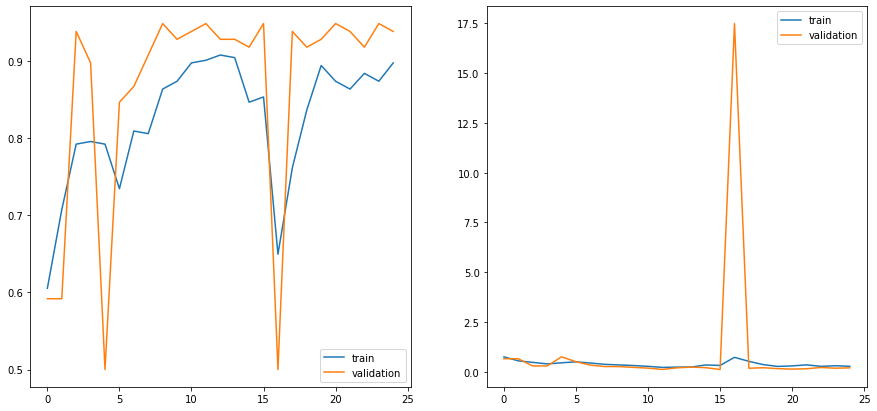

In [ ]:
plot_loss_metrics(hist)

The probability of the patient having COVID-19 is 0.7345989942550659


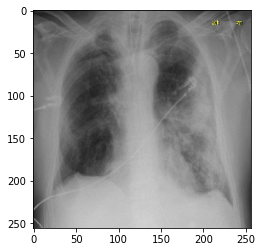

In [ ]:
img = load_img(cov)
img
preds(cov, model2, '/content/best_weights2.hdf5')

The probability of the patient not having COVID-19 is 0.9466975331306458


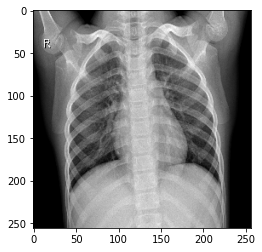

In [ ]:
img = load_img(nr)
img
preds(nr, model2, '/content/best_weights2.hdf5')

FOR COVID POSITIVE PATIENTS:
-----------------------------
The probability of the patient having COVID-19 is 0.7517402768135071
----------------------------
The probability of the patient having COVID-19 is 0.42156296968460083
----------------------------
The probability of the patient having COVID-19 is 0.943994015455246
----------------------------
The probability of the patient having COVID-19 is 0.7564666867256165
----------------------------
The probability of the patient having COVID-19 is 0.6946749687194824
----------------------------
------------------------------
FOR NORMAL PATIENTS:
The probability of the patient not having COVID-19 is 0.9488253593444824
----------------------------
The probability of the patient not having COVID-19 is 0.8969548940658569
----------------------------
The probability of the patient not having COVID-19 is 0.8502839803695679
----------------------------
The probability of the patient not having COVID-19 is 0.9245355129241943
--------------------

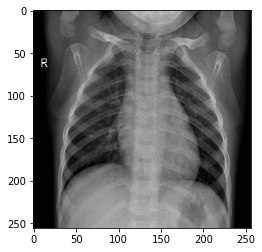

In [ ]:
random_preds(model2, '/content/best_weights2.hdf5')

The probability of the patient having COVID-19 is 0.8607502579689026


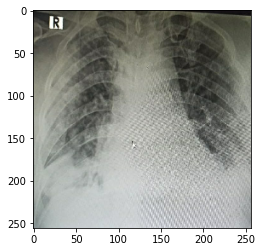

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model2, '/content/best_weights2.hdf5') 

In [ ]:
dump(model2, 'CNNdeep.joblib')

INFO:tensorflow:Assets written to: ram://7416f6fe-365f-4327-839e-f20bcdfd120c/assets


['CNNdeep.joblib']

### 4. Pre-trained Models

#### `VGG-16`

In [ ]:
train_iter, val_iter = DataGen(train_path, val_path, preprocess_func = preprocess_vgg, scale = 1)

Found 294 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [ ]:
def VGG_trainable_model():
  base_model = VGG16(include_top=False, input_shape=(256, 256, 3))
  base_model.trainable = False
  model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(512, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dense(units=1, activation='sigmoid')                                     
                      ]) 
  return model

In [ ]:
model4 = VGG_trainable_model() 
path = 'best_weight4.hdf5'
my_callbacks = [EarlyStopping(monitor='loss', patience=5),
    ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
]

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
hist = train_model(model4, loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'], callbacks = my_callbacks)

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9150
Epoch 1: val_accuracy improved from -inf to 0.95918, saving model to best_weight4.hdf5
37/37 [==============================] - 289s 8s/step - loss: 0.2251 - accuracy: 0.9150 - val_loss: 0.2239 - val_accuracy: 0.9592
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.95918 to 0.97959, saving model to best_weight4.hdf5
37/37 [==============================] - 279s 8s/step - loss: 0.1979 - accuracy: 0.9252 - val_loss: 0.0911 - val_accuracy: 0.9796
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9660
Epoch 3: val_accuracy improved from 0.97959 to 0.98980, saving model to best_weight4.hdf5
37/37 [==============================] - 280s 8s/step - loss: 0.0826 - accuracy: 0.9660 - val_loss: 0.0564 - val_accuracy: 0.9898
Epoch 4/25
37/37 [==============================] - ETA: 0s -

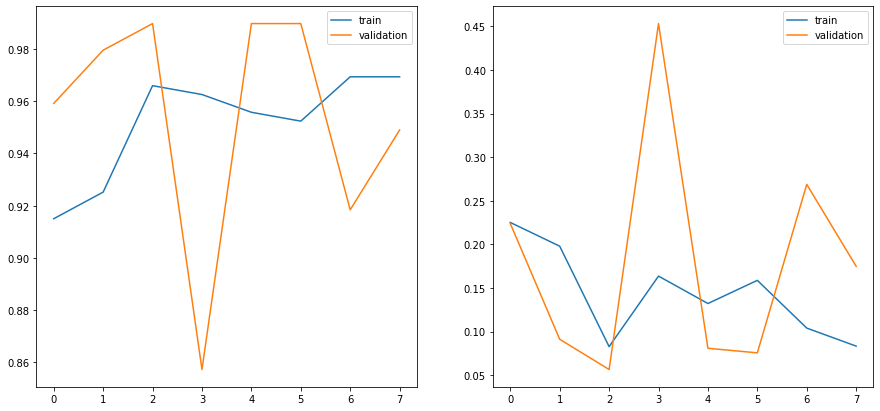

In [ ]:
plot_loss_metrics(hist)

The probability of the patient having COVID-19 is 0.9999996552039931


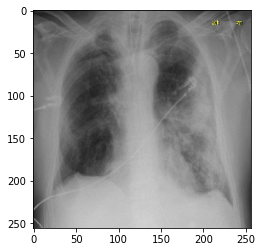

In [ ]:
img = load_img(cov)
img
preds(cov, model4, '/content/best_weight4.hdf5', preprocess = preprocess_vgg)

The probability of the patient not having COVID-19 is 0.9999802708625793


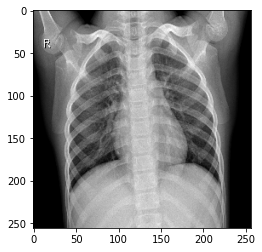

In [ ]:
img = load_img(nr)
img
preds(nr, model4, '/content/best_weight4.hdf5', preprocess = preprocess_vgg)

FOR COVID POSITIVE PATIENTS:
-----------------------------
The probability of the patient having COVID-19 is 0.9999896407098277
----------------------------
The probability of the patient having COVID-19 is 0.9999987748026342
----------------------------
The probability of the patient having COVID-19 is 0.9999999972557094
----------------------------
The probability of the patient having COVID-19 is 0.999391496181488
----------------------------
The probability of the patient having COVID-19 is 0.9999996552039931
----------------------------
------------------------------
FOR NORMAL PATIENTS:
The probability of the patient not having COVID-19 is 0.9999967217445374
----------------------------
The probability of the patient not having COVID-19 is 0.9999951124191284
----------------------------
The probability of the patient not having COVID-19 is 1.0
----------------------------
The probability of the patient not having COVID-19 is 0.9999998211860657
----------------------------
The pro

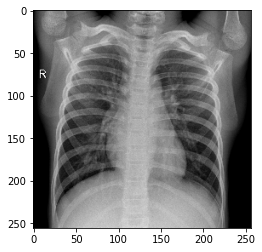

In [ ]:
random_preds(model4, '/content/best_weight4.hdf5', preprocess = preprocess_vgg)

The probability of the patient having COVID-19 is 0.999394565820694


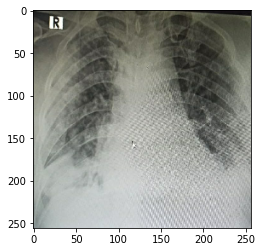

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model4, '/content/best_weight4.hdf5', preprocess = preprocess_vgg)

In [ ]:
dump(model4, 'VGG16.joblib')

INFO:tensorflow:Assets written to: ram://e73ec82c-dcf6-4901-991b-1c27699438fa/assets


['VGG16.joblib']

#### `Inception`

In [ ]:
train_iter, val_iter = DataGen(train_path, val_path, preprocess_func = preprocess_IV3, scale = 1)

Found 294 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [ ]:
def IV3_trainable_model():
  base_model = InceptionV3(include_top=False, input_shape=(256, 256, 3))
  base_model.trainable = False
  model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(512, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dense(units=1, activation='sigmoid')                                     
                      ]) 
  return model

In [ ]:
model5 = IV3_trainable_model() 
path = 'best_weight5.hdf5'
my_callbacks = [EarlyStopping(monitor='loss', patience=10),
    ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
]

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
hist = train_model(model5, loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'], callbacks = my_callbacks)

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8946
Epoch 1: val_accuracy improved from -inf to 0.93878, saving model to best_weight5.hdf5
37/37 [==============================] - 86s 2s/step - loss: 0.3007 - accuracy: 0.8946 - val_loss: 0.1245 - val_accuracy: 0.9388
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9082
Epoch 2: val_accuracy improved from 0.93878 to 0.97959, saving model to best_weight5.hdf5
37/37 [==============================] - 76s 2s/step - loss: 0.2809 - accuracy: 0.9082 - val_loss: 0.0491 - val_accuracy: 0.9796
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9490
Epoch 3: val_accuracy did not improve from 0.97959
37/37 [==============================] - 75s 2s/step - loss: 0.1911 - accuracy: 0.9490 - val_loss: 0.1079 - val_accuracy: 0.9796
Epoch 4/25
37/37 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.9082
Epoch 4: 

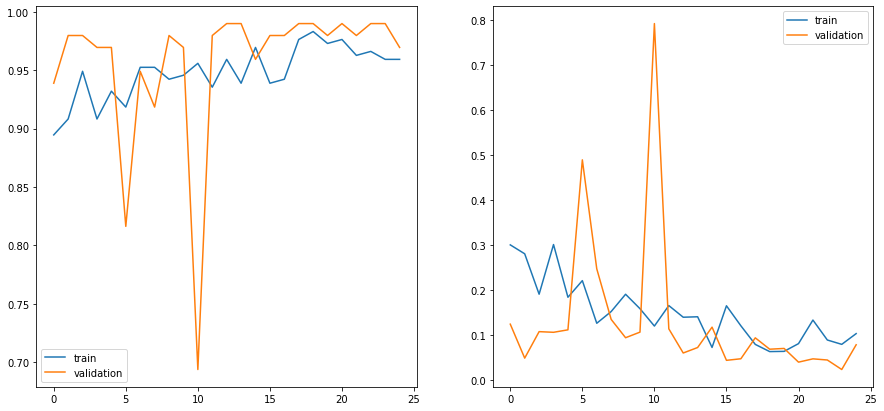

In [ ]:
plot_loss_metrics(hist)

The probability of the patient having COVID-19 is 0.999992324208506


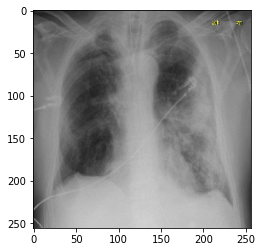

In [ ]:
img = load_img(cov)
img
preds(cov, model5, '/content/best_weight5.hdf5', preprocess = preprocess_IV3)

The probability of the patient not having COVID-19 is 0.9996490478515625


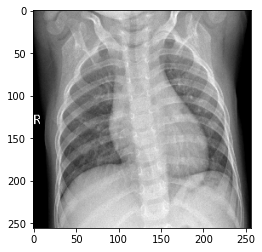

In [ ]:
nr2 = '/content/drive/MyDrive/COVID-19 Project/Dataset/test/NORMAL/IM-0523-0001.jpeg'
img = load_img(nr2)
img
preds(nr2, model5, '/content/best_weight5.hdf5', preprocess = preprocess_IV3)

FOR COVID POSITIVE PATIENTS:
-----------------------------
The probability of the patient having COVID-19 is 0.9957145154476166
----------------------------
The probability of the patient having COVID-19 is 0.9859721064567566
----------------------------
The probability of the patient having COVID-19 is 0.9999817065418029
----------------------------
The probability of the patient having COVID-19 is 0.9999999207020664
----------------------------
The probability of the patient having COVID-19 is 0.9999978200905844
----------------------------
------------------------------
FOR NORMAL PATIENTS:
The probability of the patient having COVID-19 is 0.966000884771347
----------------------------
The probability of the patient not having COVID-19 is 0.9975731372833252
----------------------------
The probability of the patient not having COVID-19 is 0.9998250603675842
----------------------------
The probability of the patient not having COVID-19 is 0.9988993406295776
-------------------------

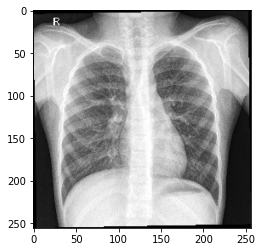

In [ ]:
random_preds(model5, '/content/best_weight5.hdf5', preprocess = preprocess_IV3)

The probability of the patient having COVID-19 is 0.9997913539409637


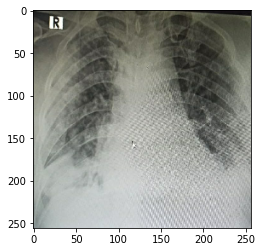

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model5, '/content/best_weight5.hdf5', preprocess = preprocess_IV3)

In [ ]:
dump(model5, 'InceptionV3.joblib')

INFO:tensorflow:Assets written to: ram://b9309796-3af5-4fca-8d9f-9e21ba2d1a15/assets


['InceptionV3.joblib']

#### `ResNet`

In [ ]:
train_iter, val_iter = DataGen(train_path, val_path, preprocess_func = preprocess_RN, scale = 1)

Found 294 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [ ]:
def ResNet_trainable_model():
  base_model = ResNet50(include_top=False, input_shape=(256, 256, 3))
  base_model.trainable = False
  model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(512, activation='relu', kernel_initializer = 'he_normal'),
                      BatchNormalization(),
                      Dense(units=1, activation='sigmoid')                                     
                      ]) 
  return model

In [ ]:
model6 = ResNet_trainable_model() 
path = 'best_weight6.hdf5'
my_callbacks = [EarlyStopping(monitor='loss', patience=10),
    ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
]

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [ ]:
hist = train_model(model6, loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'], callbacks = my_callbacks)

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9014
Epoch 1: val_accuracy improved from -inf to 0.97959, saving model to best_weight6.hdf5
37/37 [==============================] - 201s 5s/step - loss: 0.2786 - accuracy: 0.9014 - val_loss: 0.0698 - val_accuracy: 0.9796
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.97959 to 0.98980, saving model to best_weight6.hdf5
37/37 [==============================] - 98s 3s/step - loss: 0.2091 - accuracy: 0.9252 - val_loss: 0.1026 - val_accuracy: 0.9898
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9762
Epoch 3: val_accuracy did not improve from 0.98980
37/37 [==============================] - 98s 3s/step - loss: 0.0715 - accuracy: 0.9762 - val_loss: 0.0676 - val_accuracy: 0.9694
Epoch 4/25
37/37 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9320
Epoch 4:

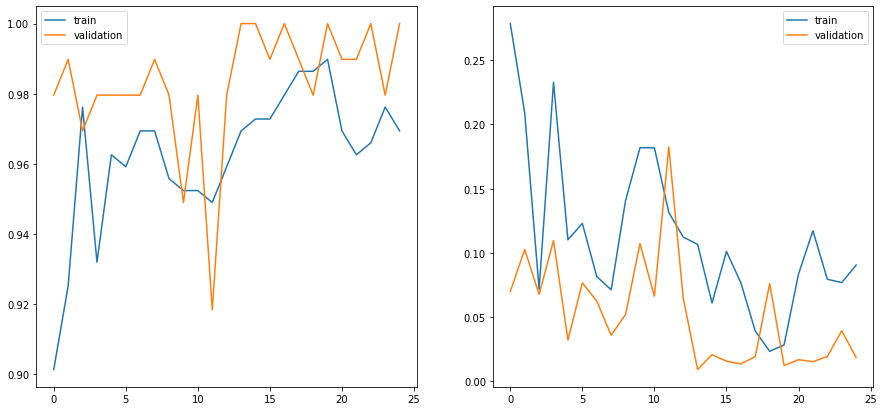

In [ ]:
plot_loss_metrics(hist)

The probability of the patient having COVID-19 is 0.9999948923373267


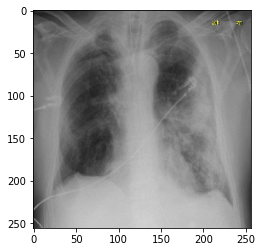

In [ ]:
img = load_img(cov)
img
preds(cov, model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

The probability of the patient not having COVID-19 is 0.9999446868896484


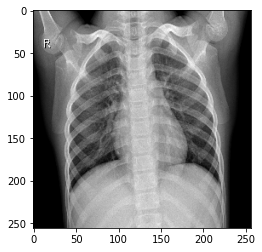

In [ ]:
img = load_img(nr)
img
preds(nr, model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

FOR COVID POSITIVE PATIENTS:
-----------------------------
The probability of the patient having COVID-19 is 0.9998247623443604
----------------------------
The probability of the patient having COVID-19 is 0.9970561265945435
----------------------------
The probability of the patient having COVID-19 is 0.9999004132405389
----------------------------
The probability of the patient having COVID-19 is 0.9979028701782227
----------------------------
The probability of the patient having COVID-19 is 0.9970104098320007
----------------------------
------------------------------
FOR NORMAL PATIENTS:
The probability of the patient not having COVID-19 is 0.999434232711792
----------------------------
The probability of the patient not having COVID-19 is 0.9999439716339111
----------------------------
The probability of the patient not having COVID-19 is 0.9999822378158569
----------------------------
The probability of the patient not having COVID-19 is 0.999825656414032
----------------------

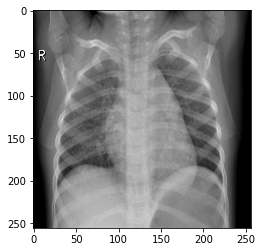

In [ ]:
random_preds(model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

The probability of the patient having COVID-19 is 0.9999116281178431


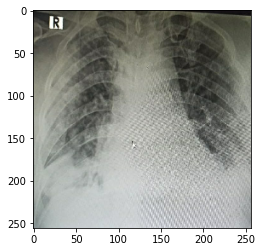

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

In [ ]:
model_json = model6.to_json()
with open('model_arch.json', 'w') as json_file:
  json_file.write(model_json)

model6.load_weights('/content/best_weight6.hdf5')
model6.save_weights('my_model_weights.hdf5')

In [ ]:
dump(model6, 'ResNet.hdf5')

INFO:tensorflow:Assets written to: ram://fcdfd65b-3fe2-49e8-bf51-e900b762cb8f/assets


['ResNet.hdf5']

In [ ]:
mod = load('/content/ResNet.hdf5')

The probability of the patient having COVID-19 is 0.9999116281178431


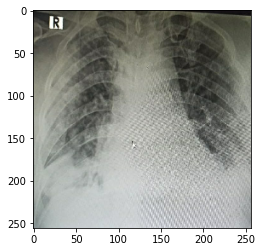

In [ ]:
img_test = load_img(path1)
img_test
preds(path1, model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

The probability of the patient having COVID-19 is 0.7358813881874084


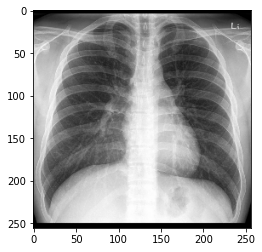

In [ ]:
img_test = load_img('/content/drive/MyDrive/COVID-19 Project/Xray_normal.jpg')
img_test
preds('/content/drive/MyDrive/COVID-19 Project/Xray_normal.jpg', model6, '/content/best_weight6.hdf5', preprocess = preprocess_RN)

## `Model Selection`

In [ ]:
data = {'Model':['SimpleCNN', 'DeepCNN', 'VGG-16', 'Inception-V3', 'ResNet50'],
        'Train Accuracy': [91.16, 86.39, 96.60, 95.92, 96.60],
        'Validation Accuracy': [96.94, 94.9, 98.98, 98.98, 98.98]}

perf = pd.DataFrame(data = data)

In [ ]:
perf

,Model,Train Accuracy,Validation Accuracy
0,SimpleCNN,91.16,96.94
1,DeepCNN,86.39,94.90
2,VGG-16,96.60,98.98
3,Inception-V3,95.92,98.98
4,ResNet50,96.60,98.98


`VGG-16` and `ResNet50` are performing the best on our dataset. So we can use any one of them for our deployment.